In [22]:
import pandas as pd
import os
import json

import pickle
from kg import KnowledgeGraph


# def create_nodes_pkl(data_dir):
#     """
#     Create node pickle file from KG node ensemble data.
    
#     Args:
#     	data_dir (str): Path of the data directory
#     """
#     nodes_df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/KG_node_map_ensembl_ids.txt', sep='\t', usecols=list(range(1, 7)))
    
#     pd.to_pickle(nodes_df, '{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl')


def add_node_indices(nodes_df, relations_df):
    """
    Add node indices from nodes dataframe to relations dataframe based on ID and type matching.
    
    Args:
    	nodes_df (pd.DataFrame): Dataframe containing node information with columns: node_idx, node_id, node_type
    	relations_df (pd.DataFrame): Dataframe containing relation information with columns: x_id, x_type, y_id, y_type
    
    Returns:
    	pd.DataFrame: Filtered relations dataframe with added x_idx, y_idx, and included columns
    """
    # Create a copy of the relations dataframe to avoid modifying the original
    result_df = relations_df.copy()
    
    # Convert node_id to string type in nodes_df for consistent matching
    nodes_df = nodes_df.copy()
    nodes_df['node_id'] = nodes_df['node_id'].astype(str)
    
    # Convert x_id and y_id to string type in relations_df
    result_df['x_id'] = result_df['x_id'].astype(str)
    result_df['y_id'] = result_df['y_id'].astype(str)
    
    # Create a mapping dictionary from (node_id, node_type) to node_idx
    node_mapping = pd.Series(
        nodes_df.node_idx.values,
        index=pd.MultiIndex.from_arrays([nodes_df.node_id, nodes_df.node_type])
    ).to_dict()
    
    # Create a function to safely get mapping value
    def get_mapping(row, id_col, type_col):
        key = (row[id_col], row[type_col])
        return node_mapping.get(key)
    
    # Add x_idx column by mapping (x_id, x_type)
    result_df['x_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'x_id', 'x_type'), 
        axis=1
    )
    
    # Add y_idx column by mapping (y_id, y_type)
    result_df['y_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'y_id', 'y_type'), 
        axis=1
    )
    
    # Check if both indices are valid (not NaN) and add 'included' column
    result_df['included'] = result_df['x_idx'].notna() & result_df['y_idx'].notna()
    
    # Filter rows where both x_idx and y_idx are not NaN
    result_df = result_df[result_df['included']].copy()
    
    # Convert x_idx and y_idx to integers
    result_df['x_idx'] = result_df['x_idx'].astype(int)
    result_df['y_idx'] = result_df['y_idx'].astype(int)
    
    return result_df


data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')
print("Loading HPO to index dictionary...")

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/hpo_to_idx_dict_8.9.21_kg.pkl', 'rb') as f:
    hpo_to_idx_dict = pickle.load(f)

print("Loading Genes to index dictionary...")
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/ensembl_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    genes = pickle.load(file)

with open(f'{data_dir}/preprocess/orphanet/orphanet_to_mondo_dict.pkl', 'rb') as file:
        orphanet_to_mondo_dict = pickle.load(file)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/mondo_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    mondo_to_idx_dict = pickle.load(file)

# create_nodes_pkl(data_dir)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

/tmp/ipykernel_19844/13880158.py:82: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')


Loading HPO to index dictionary...
Loading Genes to index dictionary...


In [ ]:
# Example usage
result = add_node_indices(nodes, df)
result.to_csv(f'{output_dir}/result.csv', index=False)

# # Initialize KG
kg = KnowledgeGraph()

# # Load data with chunks
kg.create_from_csv(
    filepath=f'./{output_dir}/result.csv',
    nodes_filepath = f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl',
    chunksize=100000,  # Adjust based on your memory constraints
    show_progress=True
)

# Save the graph
kg.save_graph(f'{output_dir}/my_graph_ids.graphml')


# code to double check the KG 
subgraph = kg.plot_random_subgraph(num_nodes=45, method='random_walk')

Loading nodes from ./Data/knowledge_graph/8.9.21_kg/nodes.pkl
Loaded 105,220 nodes
Error loading nodes pickle file: 'dict' object has no attribute 'columns'


AttributeError: 'dict' object has no attribute 'columns'

In [14]:
# # # Initialize KG
kg = KnowledgeGraph()
kg.load_graph(f'{output_dir}/my_graph_ids.graphml') #!!!!!!! if u want proper plotting u need to save and then load the graph, not work directly after creation the kg 

# WORKING with PATINIET DATA

print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]



val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

val_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in val_data
]

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(train_patients_phenotypes_list, f)

train_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in train_data
]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_genes.pkl', 'wb') as f:
    pickle.dump(val_patients_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_genes.pkl', 'wb') as f:
    pickle.dump(train_patients_genes, f)


val_all_candidate_genes = [
    [genes[g] for g in p['all_candidate_genes'] if g in genes]
    for p in val_data
]

# Save the list to a pickle file
with open(f'{output_dir}/val_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(val_all_candidate_genes, f)


train_all_candidate_genes = [
    [genes[g] for g in p['all_candidate_genes'] if g in genes]
    for p in train_data
]

# Save the list to a pickle file
with open(f'{output_dir}/train_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(train_all_candidate_genes, f)

print("Saved all preprocessed files regarding patient data.")

# add here the test data

FileNotFoundError: [Errno 2] No such file or directory: './Output/my_graph_ids.graphml'

In [9]:
train_data[0]

{'true_genes': ['ENSG00000146085'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000124',
  'HP:0001249',
  'HP:0001254',
  'HP:0001259',
  'HP:0001252',
  'HP:0001510',
  'HP:0002017',
  'HP:0004374',
  'HP:0410042',
  'HP:0001903',
  'HP:0100806',
  'HP:0001279',
  'HP:0000712',
  'HP:0100739',
  'HP:0031009',
  'HP:0001363',
  'HP:0001360'],
 'negative_phenotypes': {'HP:0000083': ['init_phenotypes'],
  'HP:0001019': ['phenotype_distractor.9'],
  'HP:0002716': ['phenotype_distractor.9'],
  'HP:0002240': ['phenotype_distractor.9'],
  'HP:0000643': ['noisy_phenotype'],
  'HP:0001369': ['noisy_phenotype'],
  'HP:0008226': ['noisy_phenotype']},
 'n_distractor_genes': 11,
 'distractor_genes': ['ENSG00000143727',
  'ENSG00000014216',
  'ENSG00000158352',
  'ENSG00000105664',
  'ENSG00000197915',
  'ENSG00000157766',
  'ENSG00000188994',
  'ENSG00000095464',
  'ENSG00000132155',
  'ENSG00000152457',
  'ENSG00000168056'],
 'dropout_phenotypes': {'positive_phenotypes': ['HP:0001733',

In [ ]:
# Preprocces the test data

# File path to your text file
file_path = f'{data_dir}/patients/mygene2_patients/mygene2_5.7.22.txt'  # val data!!!!

with open(file_path, 'r') as f:
    test_data = [json.loads(line) for line in f]

In [11]:
test_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in test_data]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(test_patients_phenotypes_list, f)

test_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in test_data
]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_genes.pkl', 'wb') as f:
    pickle.dump(test_patients_genes, f)


test_all_candidate_genes = [
    [genes[g] for g in p['all_candidate_genes'] if g in genes]
    for p in test_data
]

# Save the list to a pickle file
with open(f'{output_dir}/test_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(test_all_candidate_genes, f)


print('Saved all preprocessed files regarding patient data.')

Saved all preprocessed files regarding patient data.


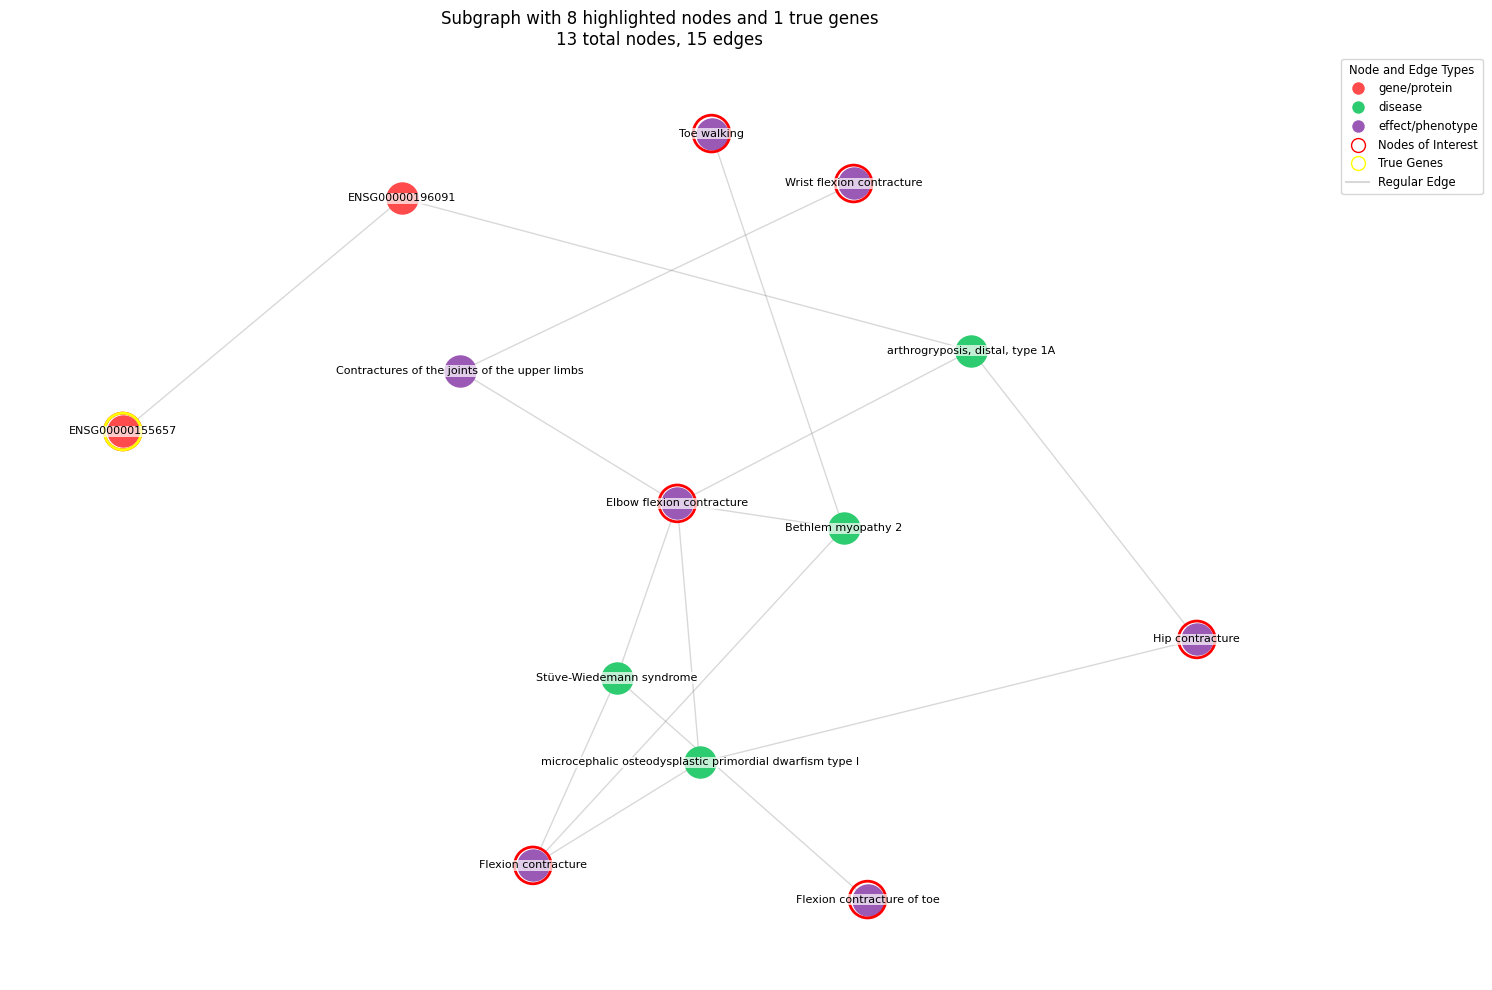

In [12]:
# plot the subgraph from val and from test
# check if the subgraphs are connected or not 

i=0
kg.visualize_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])

In [13]:
train_nx_subgraph = []
train_pg_subgraph = []

for i in range(len(train_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in train_patients_phenotypes_list[i] + train_all_candidate_genes[i] + train_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in train_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    train_nx_subgraph.append(subgraph)
    train_pg_subgraph.append(pg_graph)

In [14]:
val_nx_subgraph = []
val_pg_subgraph = []

for i in range(len(val_patients_phenotypes_list)):

    # Without patients
    subgraph = kg.create_subgraph([str(n) for n in val_patients_phenotypes_list[i]+ val_all_candidate_genes[i]+ val_patients_genes[i]], true_gene_ids = [str(k) for k in val_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    val_nx_subgraph.append(subgraph)
    val_pg_subgraph.append(pg_graph)

In [15]:
test_nx_subgraph = []
test_pg_subgraph = []

for i in range(len(test_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    test_nx_subgraph.append(subgraph)
    test_pg_subgraph.append(pg_graph)

In [ ]:
import torch
lookup = torch.nn.Embedding(num_nodes,dim=256) #105 200
emb = lookup(23)
add dataloader example 

pg_graph.x = lookup([pg_graph.node_mapping.key()])

x = encoder(pg_graph.x, pg_graph.edge_index)
x.shape = 14, dim

In [ ]:
pg_graph.true_gene_ids

In [ ]:
pg_graph.node_mapping.key()

In [ ]:
pg_graph.edge_attr.shape

In [ ]:
pg_graph.edge_index.shape

In [ ]:
subgraph.nodes(data=True)

In [16]:
import networkx as nx

# Assuming test_nx_subgraph is a list of graphs
subgraph = train_nx_subgraph[3]  # First subgraph

# Check if the graph is directed
is_directed = subgraph.is_directed()

# Check if the graph is connected
# For directed graphs, check strongly connected or weakly connected
if is_directed:
    is_connected = nx.is_strongly_connected(subgraph)  # Strongly connected
    is_weakly_connected = nx.is_weakly_connected(subgraph)  # Weakly connected
    print(f"Graph is directed: {is_directed}")
    print(f"Graph is strongly connected: {is_connected}")
    print(f"Graph is weakly connected: {is_weakly_connected}")
else:
    is_connected = nx.is_connected(subgraph)  # Connected (undirected case)
    print(f"Graph is directed: {is_directed}")
    print(f"Graph is connected: {is_connected}")

Graph is directed: False
Graph is connected: True


In [17]:
# Create the output directory if it doesn't exist
output_folder = './Graph Outputs'
os.makedirs(output_folder, exist_ok=True)

# Combined lists to save
lists_to_save = {
    'val_nx_subgraph': val_nx_subgraph,
    'val_pg_subgraph': val_pg_subgraph,

    'train_nx_subgraph': train_nx_subgraph,
    'train_pg_subgraph': train_pg_subgraph,

    'test_nx_subgraph': test_nx_subgraph,
    'test_pg_subgraph': test_pg_subgraph,

}

# Save each list using pickle
for list_name, list_data in lists_to_save.items():
    file_path = os.path.join(output_folder, f'{list_name}.pkl')
    with open(file_path, 'wb') as file:
        pickle.dump(list_data, file)
    print(f'Saved {list_name} to {file_path}')

Saved val_nx_subgraph to ./Graph Outputs\val_nx_subgraph.pkl
Saved val_pg_subgraph to ./Graph Outputs\val_pg_subgraph.pkl
Saved train_nx_subgraph to ./Graph Outputs\train_nx_subgraph.pkl
Saved train_pg_subgraph to ./Graph Outputs\train_pg_subgraph.pkl
Saved test_nx_subgraph to ./Graph Outputs\test_nx_subgraph.pkl
Saved test_pg_subgraph to ./Graph Outputs\test_pg_subgraph.pkl
